COMP-6651 - Algorithm Design Techniques

Project - Clustering Algorithms Analysis

BIRCH Experimentation

Author - Sotirios Damas - 40317602

In [ ]:
import numpy as np
from numpy.linalg import det, inv
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (calinski_harabasz_score, silhouette_score,
                             davies_bouldin_score, adjusted_rand_score,
                             normalized_mutual_info_score)
from scipy.spatial.distance import pdist, squareform
import kagglehub

In [ ]:
path_iris = kagglehub.dataset_download("himanshunakrani/iris-dataset")
f_path_iris = os.path.join(path_iris, 'iris.csv')
iris_df = pd.read_csv(f_path_iris)
# Extract labels (species)
iris_labels = iris_df['species']
# Remove label from the features
iris_features = iris_df.drop(columns=['species'])
# Convert to numpy
iris_data = iris_features.values


# Preprocessing for AI Global Index Dataset
def preprocess_ai_index(data):
    # Separate numerical and categorical columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns

    scaler = MinMaxScaler()
    num_scaled = scaler.fit_transform(data[numeric_cols]) if len(numeric_cols) > 0 else np.array([])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_encoded = encoder.fit_transform(data[categorical_cols]) if len(categorical_cols) > 0 else np.array([])

    if num_scaled.size and cat_encoded.size:
        return np.hstack((num_scaled, cat_encoded))
    elif num_scaled.size:
        return num_scaled
    else:
        return cat_encoded

path_ai_index = kagglehub.dataset_download("katerynameleshenko/ai-index")
f_path_ai_index = os.path.join(path_ai_index, 'AI_index_db.csv')
ai_df = pd.read_csv(f_path_ai_index)
ai_df = ai_df.dropna()
# Extract the 'Cluster' column as the label
ai_labels = ai_df['Cluster']
# Remove the 'Cluster' column from the features
ai_df_features = ai_df.drop(columns=['Cluster'])
# Preprocess the remaining features
ai_data = preprocess_ai_index(ai_df_features)

path_earthquakes= kagglehub.dataset_download("shreyasur965/recent-earthquakes")
f_path_earthquakes = os.path.join(path_earthquakes, 'earthquakes.csv')
earthquake_df = pd.read_csv(f_path_earthquakes)
earthquake_df = earthquake_df[['magnitude', 'felt', 'cdi','mmi','tsunami','sig','depth', 'latitude', 'longitude', 'alert']].dropna()
# Extract the alert labels
earthquake_data_alerts = earthquake_df['alert']
alert_encoded = LabelEncoder().fit_transform(earthquake_data_alerts)
# Remove the label from features
earthquake_data_features = earthquake_df.drop(columns=['alert'])
# Scale the numeric features
earthquake_data = StandardScaler().fit_transform(earthquake_data_features)

In [ ]:
def compute_diameter(X, labels):
    """
    Computes the average 'diameter' across all clusters,
    where 'diameter' of a cluster is the maximum distance
    between any two points in that cluster.
    """
    from scipy.spatial.distance import pdist, squareform

    unique_labels = np.unique(labels)
    diameters = []
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        if len(cluster_points) > 1:
            # pairwise distances in the cluster
            dist_matrix = squareform(pdist(cluster_points))
            diameters.append(dist_matrix.max())
        else:
            # A single point has diameter 0
            diameters.append(0.0)
    return np.mean(diameters)


def compute_split(X, labels):
    """
    An example 'split' metric: ratio of the size of the largest cluster
    to the size of the smallest cluster. If there's only one cluster, return 1.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    if len(counts) < 2:
        return 1.0
    return counts.max() / counts.min()


def evaluate_clustering(X, labels, true_labels=None):
    """
    Compute a set of metrics for the given clustering labels.
    Some metrics require ground truth (true_labels).
    If no true_labels is provided, ARI and MI will be omitted.
    Returns a dict of metric_name -> value.
    """
    metrics_dict = {}

    # Unsupervised metrics
    metrics_dict["Silhouette"] = silhouette_score(X, labels)
    metrics_dict["Davies-Bouldin"] = davies_bouldin_score(X, labels)
    metrics_dict["Calinski-Harabasz"] = calinski_harabasz_score(X, labels)
    metrics_dict["Diameter"] = compute_diameter(X, labels)
    metrics_dict["Split"] = compute_split(X, labels)

    # If we have ground-truth labels, we can compute supervised metrics
    if true_labels is not None:
        metrics_dict["Adjusted Rand Index"] = adjusted_rand_score(true_labels, labels)
        # Using normalized_mutual_info_score as a measure of MI
        metrics_dict["Mutual Information"] = normalized_mutual_info_score(true_labels, labels)

    return metrics_dict


In [ ]:
def multivariate_gaussian_pdf(x, mean, cov):
    """
    Compute the multivariate Gaussian probability density function value for x.
    x: 1D array of shape (d,)
    mean: 1D array of shape (d,)
    cov: 2D array of shape (d, d)
    """
    d = x.shape[0]
    # Add small regularization to the covariance to avoid singularities
    cov_reg = cov + 1e-3 * np.eye(d)
    det_cov = det(cov_reg)
    inv_cov = inv(cov_reg)

    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def initialize_gmm_params(X, K, init_method='random', random_state=None):
    """
    Initialize GMM parameters: means, covariances, mixing coefficients.
    X: array of shape (n, d)
    K: number of components
    If random_state is provided, use it to seed the random number generator.
    """

    if random_state is not None:
        np.random.seed(random_state)

    n, d = X.shape

    # Initialize mixing coefficients to be uniform
    pi_k = np.ones(K) / K

    # Initialize means: randomly select K points from X
    indices = np.random.choice(n, K, replace=False)
    means = X[indices]

    # Initialize covariances to identity or to the overall data covariance
    covariances = np.array([np.cov(X, rowvar=False) for _ in range(K)])

    return means, covariances, pi_k

def gmm_em_algorithm(X, K, max_iters=100, tol=1e-4, random_state=None):
    """
    A naive EM algorithm for GMM with full covariance matrices.
    X: array of shape (n, d)
    K: number of components
    max_iters: maximum number of EM iterations
    tol: convergence threshold for log-likelihood improvement

    Returns:
      pi_k: array of shape (K,)
      means: array of shape (K, d)
      covariances: array of shape (K, d, d)
      gamma: array of shape (n, K) (responsibilities)
    """
    n, d = X.shape

    # Initialize parameters
    means, covariances, pi_k = initialize_gmm_params(X, K, init_method='random', random_state=random_state)

    # Pre-allocate responsibilities
    gamma = np.zeros((n, K))

    log_likelihood_old = -np.inf

    for iteration in range(max_iters):
        # E-step: compute responsibilities gamma[i, k]
        for i in range(n):
            for k in range(K):
                gamma[i, k] = pi_k[k] * multivariate_gaussian_pdf(X[i], means[k], covariances[k])
            # Normalize over k
            total = np.sum(gamma[i, :])
            if total > 0:
                gamma[i, :] /= total

        # M-step: update pi_k, means, covariances
        Nk = np.sum(gamma, axis=0)  # shape (K,)
        for k in range(K):
            pi_k[k] = Nk[k] / n
            # Update mean
            means[k] = np.sum(gamma[:, k].reshape(-1, 1) * X, axis=0) / Nk[k]
            # Update covariance
            diff = X - means[k]
            cov_k = np.zeros((d, d))
            for i in range(n):
                cov_k += gamma[i, k] * np.outer(diff[i], diff[i])
            covariances[k] = cov_k / Nk[k]

        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for i in range(n):
            tmp = 0
            for k in range(K):
                tmp += pi_k[k] * multivariate_gaussian_pdf(X[i], means[k], covariances[k])
            if tmp > 0:
                log_likelihood += np.log(tmp)

        if np.abs(log_likelihood - log_likelihood_old) < tol:
            break
        log_likelihood_old = log_likelihood

    return pi_k, means, covariances, gamma

def gmm_predict(X, pi_k, means, covariances):
    """
    Assign each data point to the cluster with the highest responsibility.
    """
    n = X.shape[0]
    K = pi_k.shape[0]
    gamma = np.zeros((n, K))
    for i in range(n):
        for k in range(K):
            gamma[i, k] = pi_k[k] * multivariate_gaussian_pdf(X[i], means[k], covariances[k])
        total = np.sum(gamma[i, :])
        if total > 0:
            gamma[i, :] /= total

    labels = np.argmax(gamma, axis=1)
    return labels

In [ ]:
def run_gmm_experiment(name, X, K=3, max_iters=100, true_labels=None, random_state=42):
    print(f"----- {name} -----")

    # Base GMM
    pi_k, means, covariances, gamma = gmm_em_algorithm(X, K=K, max_iters=max_iters, random_state=random_state)
    base_labels = np.argmax(gamma, axis=1)
    base_metrics = evaluate_clustering(X, base_labels, true_labels=true_labels)

    # Sklearn GMM
    gm = GaussianMixture(n_components=K, covariance_type='full', max_iter=max_iters, random_state=random_state)
    gm.fit(X)
    sklearn_labels = gm.predict(X)
    sklearn_metrics = evaluate_clustering(X, sklearn_labels, true_labels=true_labels)

    print("Base GMM Metrics:")
    for metric, value in base_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print("Sklearn GMM Metrics:")
    for metric, value in sklearn_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print("-" * 40)

    return base_labels, sklearn_labels

In [ ]:
print("Running Base and Sklearn GMM on Iris Dataset")
base_labels_iris, sklearn_labels_iris = run_gmm_experiment("Iris", iris_data, K=3, true_labels=iris_labels)

Running Base and Sklearn GMM on Iris Dataset
----- Iris -----
Base GMM Metrics:
  Silhouette: 0.5009
  Davies-Bouldin: 0.7487
  Calinski-Harabasz: 480.7862
  Diameter: 2.9891
  Split: 1.2222
  Adjusted Rand Index: 0.9039
  Mutual Information: 0.8997
Sklearn GMM Metrics:
  Silhouette: 0.5009
  Davies-Bouldin: 0.7487
  Calinski-Harabasz: 480.7862
  Diameter: 2.9891
  Split: 1.2222
  Adjusted Rand Index: 0.9039
  Mutual Information: 0.8997
----------------------------------------


In [ ]:
print("Running Base and Sklearn GMM on AI Global Index Dataset")
base_labels_ai, sklearn_labels_ai = run_gmm_experiment("AI Global Index", ai_data, K=5, true_labels=ai_labels)

Running Base and Sklearn GMM on AI Global Index Dataset
----- AI Global Index -----
Base GMM Metrics:
  Silhouette: 0.0329
  Davies-Bouldin: 2.9542
  Calinski-Harabasz: 3.3900
  Diameter: 3.0702
  Split: 2.4286
  Adjusted Rand Index: 0.1064
  Mutual Information: 0.2799
Sklearn GMM Metrics:
  Silhouette: 0.1432
  Davies-Bouldin: 1.9805
  Calinski-Harabasz: 8.4275
  Diameter: 2.8962
  Split: 3.1667
  Adjusted Rand Index: 0.0807
  Mutual Information: 0.2890
----------------------------------------


In [ ]:
print("Running Base and Sklearn GMM on Earthquake Dataset")
base_labels_eq, sklearn_labels_eq = run_gmm_experiment("Earthquake", earthquake_data, K=4,true_labels=alert_encoded)

Running Base and Sklearn GMM on Earthquake Dataset
----- Earthquake -----
Base GMM Metrics:
  Silhouette: 0.2776
  Davies-Bouldin: 2.0908
  Calinski-Harabasz: 72.9708
  Diameter: 13.9876
  Split: 12.5217
  Adjusted Rand Index: 0.2772
  Mutual Information: 0.2021
Sklearn GMM Metrics:
  Silhouette: 0.2574
  Davies-Bouldin: 1.4272
  Calinski-Harabasz: 117.1058
  Diameter: 6.9570
  Split: 493.0000
  Adjusted Rand Index: 0.1774
  Mutual Information: 0.1838
----------------------------------------


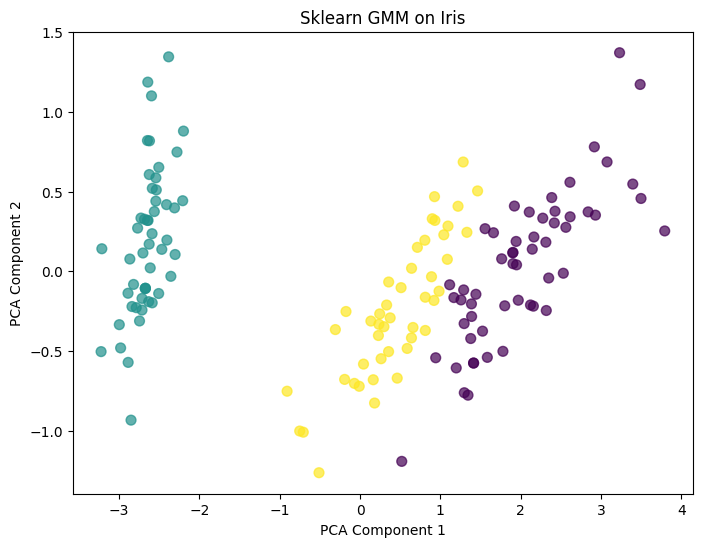

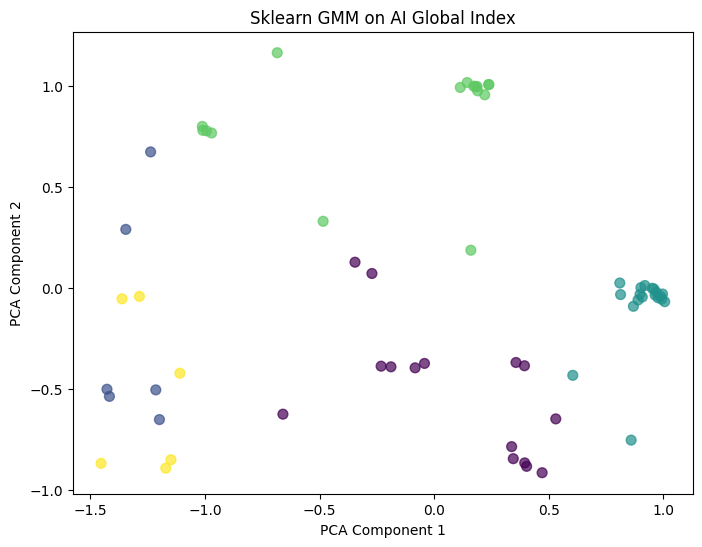

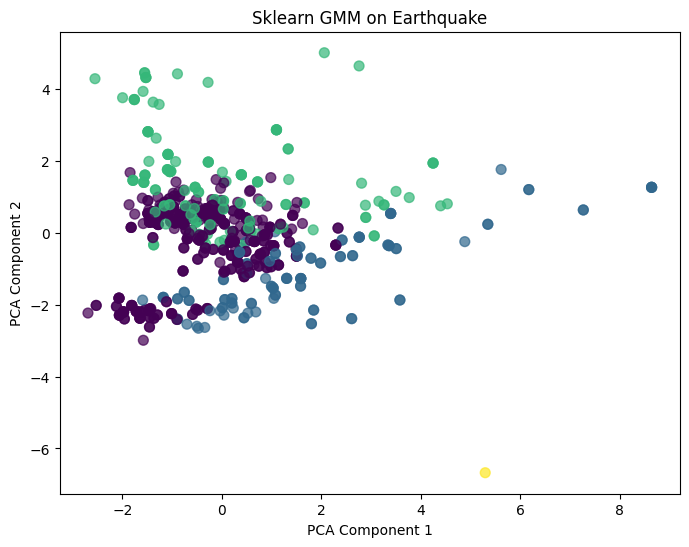

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_clusters(X, labels, title="Cluster Visualization", true_labels=None):
    """
    Reduces data to 2 dimensions using PCA and plots a scatter plot of the clusters.

    Parameters:
      X : array-like, shape (n_samples, n_features)
         The data matrix.
      labels : array-like, shape (n_samples,)
         Cluster labels to color the points.
      title : str
         Title for the plot.
      true_labels : array-like, optional
         True labels for comparison (will create an additional plot).
    """
    # Reduce data to 2 dimensions
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Plot clustering result
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    #plt.colorbar(scatter, label="Cluster Label")
    plt.show()

    # If true labels are provided, plot them for comparison
    if true_labels is not None:
        plt.figure(figsize=(8,6))
        scatter_true = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
        plt.title(title + " (True Labels)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(scatter_true, label="True Label")
        plt.show()


visualize_clusters(iris_data, sklearn_labels_iris, title="Sklearn GMM on Iris")

visualize_clusters(ai_data, sklearn_labels_ai, title="Sklearn GMM on AI Global Index")

visualize_clusters(earthquake_data, sklearn_labels_eq, title="Sklearn GMM on Earthquake")


In [ ]:
def select_top_k_features_for_alert(df, alert_col='alert', k=5):
    """
    Filters features based on Mutual Information (MI) with the alert label.
    Steps:
      1) Drop rows with any missing values (to avoid errors).
      2) Label-encode the alert column if it is categorical (e.g., text).
      3) For each feature, compute MI against the alert.
      4) Sort features by MI score, descending.
      5) Return the top k feature names.

    """
    data = df.dropna()

    # Separate the target (alert) from the features
    y = data[alert_col]
    X_df = data.drop(columns=[alert_col])

    # encode alert:
    y_enc = LabelEncoder().fit_transform(y)

    # mutual_info_classif calculates MI between each column and y_enc
    mi_scores = mutual_info_classif(X_df.values, y_enc, discrete_features=False)

    # Pair up (feature_name, mi_score)
    feats_and_scores = list(zip(X_df.columns, mi_scores))

    # Sort by MI descending
    feats_and_scores.sort(key=lambda x: x[1], reverse=True)

    # Pick top k
    top_features = [f[0] for f in feats_and_scores[:k]]

    return top_features

## 4.2 - Select the top 5 features for predicting alert

In [ ]:
top5_features = select_top_k_features_for_alert(
    earthquake_df,  # the original DataFrame with 'alert' and other columns
    alert_col='alert',
    k=5
)
print("Top 5 features most predictive of 'alert':", top5_features)

Top 5 features most predictive of 'alert': ['sig', 'mmi', 'latitude', 'longitude', 'magnitude']


## 4.3 - Re-run the clustering using only top-5 features

In [ ]:
# Subset the DataFrame to those top-5 columns
earthquake_df_top5 = earthquake_df[top5_features]

# 2) Scale the new subset
eq_top5_data = StandardScaler().fit_transform(earthquake_df_top5.values)

print("Running Base/Sklearn GMM on Earthquake Dataset with Top-5 Features")
_ = run_gmm_experiment(
    "Earthquake (Top-5 Features)",
    eq_top5_data,
    K=4,
    true_labels=alert_encoded
)


Running Base/Sklearn GMM on Earthquake Dataset with Top-5 Features
----- Earthquake (Top-5 Features) -----
Base GMM Metrics:
  Silhouette: 0.2182
  Davies-Bouldin: 3.2437
  Calinski-Harabasz: 84.8584
  Diameter: 7.5472
  Split: 8.1639
  Adjusted Rand Index: 0.2038
  Mutual Information: 0.2574
Sklearn GMM Metrics:
  Silhouette: 0.2326
  Davies-Bouldin: 1.7190
  Calinski-Harabasz: 173.3856
  Diameter: 6.7286
  Split: 4.8060
  Adjusted Rand Index: 0.0957
  Mutual Information: 0.1996
----------------------------------------
